Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


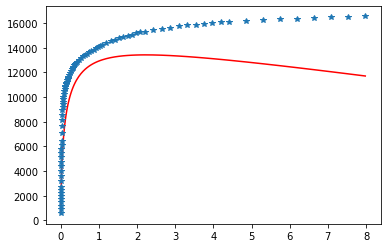

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from google.colab import drive
drive.mount('/content/drive')

#file = pd.read_excel (r'D:\dataAssimilation\Book1.xlsx', "Sheet1")
file = pd.read_excel (r'drive/MyDrive/Kumar/Book1.xlsx', "Sheet1")
X= (file['X']).values.tolist()
Y= (file['Y']).values.tolist()

X_obs=np.array(X)[10:]
Y_obs=np.array(Y)[10:]*10

#function to estimate Y with given k and n (to be assimilated), X (given displacement)



def forcastModel(k,n,xu_bar,yu_bar,x_norm,y_norm, X_obs):
    Y=np.zeros(len(X_obs))
    D= 10
    a=1-2*n
    x_bar=X_obs*x_norm
    b=2*n*(x_bar)/xu_bar - (1-n)*(1+(x_bar*k/yu_bar))
    c=x_bar*k/yu_bar*(1-n)-n*x_bar*x_bar/(xu_bar*xu_bar)
    
    for i in np.arange(len(X_obs)):  
        Y[i]=y_norm*(yu_bar*((2*c[i])/(-b[i]+math.sqrt(max(0,b[i]*b[i]-4*a*c[i])))))
    return Y


#My initial guess for the parameters
# 4 <= k <= 12
# 0 <= n <= 1
# xu_bar > yu_bar/k


#I know below guess is bad, but I can confirm the parameters after discussing with the experiment guys onl 
# 100 <=xu_bar <= 500  y
# 5 <= yu_bar <= 15
# 70 <= x_norm <= 120
# 800 <= y_norm <= 1500



#trial run with given n,k,xu_bar,yu_bar,x_norm,y_norm
Y = forcastModel(8,0.9,200,11,90,1220,X_obs)
plt.plot(X_obs,Y,'r') #from forcast model
plt.plot(X_obs,Y_obs,'*') #Corrected observation


In [ ]:
!pip install smt
!pip install adao

In [5]:
from smt.sampling_methods import LHS
from adao import adaoBuilder
from sklearn.preprocessing import PolynomialFeatures

# without bounds

In [47]:
x_b = np.array([8,0.9,200,11,90,1220])


def f(x):
  return forcastModel(x[0],x[1],x[2],x[3],x[4],x[5], X_obs)

  #return X
case = adaoBuilder.New()
case.set( 'AlgorithmParameters', Algorithm='3DVAR',
          Parameters = {"Minimizer" : "LBFGSB","MaximumNumberOfSteps":100,
                        #"Bounds":[[5,12],[0,1]],
                       # "CostDecrementTolerance":1.e-5,
                        "StoreSupplementaryCalculations":["CostFunctionJ","CurrentState",
                        "SimulatedObservationAtOptimum",
                        "SimulatedObservationAtBackground",
                        "JacobianMatrixAtBackground",
                        "JacobianMatrixAtOptimum",
                        "KalmanGainAtOptimum",
                        "APosterioriCovariance"]
                        } )
case.set( 'Background',          Vector=x_b)
case.set( 'BackgroundError',     ScalarSparseMatrix=10000.0 )
case.set( 'Observation',         Vector=Y_obs )
case.set( 'ObservationError',    ScalarSparseMatrix=1.0 )
case.set( 'ObservationOperator', OneFunction = f)
case.set( 'Observer',            Variable="Analysis", Template="ValuePrinter" )

case.setObserver(Variable="CostFunctionJ",Template="ValuePrinter")
case.setObserver(Variable="CostFunctionJo",Template="ValuePrinter")
case.setObserver(Variable="CostFunctionJb",Template="ValuePrinter")
case.setObserver(Variable="Analysis",Template="ValuePrinter")
case.execute()

x_a = case.get("Analysis")[-1]

CostFunctionJb 0.0
CostFunctionJo 253728148.20443782
CostFunctionJ 253728148.20443782
CostFunctionJb 5e-05
CostFunctionJo 543300012.6539091
CostFunctionJ 543300012.653959
CostFunctionJb 4.472850614484882e-06
CostFunctionJo 85350796.06987506
CostFunctionJ 85350796.06987953
CostFunctionJb 4.277441416162153e-06
CostFunctionJo 84392015.23198606
CostFunctionJ 84392015.23199034
CostFunctionJb 3.5968540176102993e-06
CostFunctionJo 81194068.24097273
CostFunctionJ 81194068.24097632
CostFunctionJb 3.5025853133422404e-06
CostFunctionJo 74529828.91356842
CostFunctionJ 74529828.91357192
CostFunctionJb 5.416718282477711e-06
CostFunctionJo 68838439.45433475
CostFunctionJ 68838439.45434017
CostFunctionJb 2.095923548274327e-05
CostFunctionJo 50999245.84931101
CostFunctionJ 50999245.84933197
CostFunctionJb 8.667308618896839e-05
CostFunctionJo 35477020.50931645
CostFunctionJ 35477020.509403124
CostFunctionJb 9.227797874690095e-05
CostFunctionJo 33689995.202196315
CostFunctionJ 33689995.20228859
CostFunct

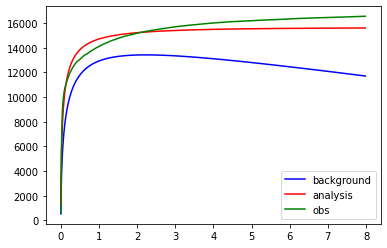

In [39]:
X= (file['X']).values.tolist()[10:]
Y_obs= (file['Y']).values.tolist()[10:]
plt.plot(X,f(x_b),'b',label = 'background')
plt.plot(X,f(x_a),'r',label = 'analysis')
plt.plot(X,np.array(Y_obs)*10,'g',label = 'obs')
plt.legend()

In [48]:
x_a

array([1.92432182e+02, 9.62101815e-01, 2.37871392e+02, 1.27839095e+01,
       2.12783180e+01, 1.22118799e+03])

# with bounds

In [43]:
x_b = np.array([8,0.9,200,11,90,1220])

# 4 <= k <= 12
# 0 <= n <= 1

# 100 <=xu_bar <= 500  
# 5 <= yu_bar <= 15
# 70 <= x_norm <= 120
# 800 <= y_norm <= 1500

def f(x):
  return forcastModel(x[0],x[1],x[2],x[3],x[4],x[5], X_obs)

  #return X
case = adaoBuilder.New()
case.set( 'AlgorithmParameters', Algorithm='3DVAR',
          Parameters = {"Minimizer" : "LBFGSB","MaximumNumberOfSteps":100,
                        "Bounds":[[4,12],[0,1],[100,500],[5,15],[70,120],[800,1500]],
                       # "CostDecrementTolerance":1.e-5,
                        "StoreSupplementaryCalculations":["CostFunctionJ","CurrentState",
                        "SimulatedObservationAtOptimum",
                        "SimulatedObservationAtBackground",
                        "JacobianMatrixAtBackground",
                        "JacobianMatrixAtOptimum",
                        "KalmanGainAtOptimum",
                        "APosterioriCovariance"]
                        } )
case.set( 'Background',          Vector=x_b)
case.set( 'BackgroundError',     ScalarSparseMatrix=10000.0 )
case.set( 'Observation',         Vector=Y_obs )
case.set( 'ObservationError',    ScalarSparseMatrix=1.0 )
case.set( 'ObservationOperator', OneFunction = f)
case.set( 'Observer',            Variable="Analysis", Template="ValuePrinter" )

case.setObserver(Variable="CostFunctionJ",Template="ValuePrinter")
case.setObserver(Variable="CostFunctionJo",Template="ValuePrinter")
case.setObserver(Variable="CostFunctionJb",Template="ValuePrinter")
case.setObserver(Variable="Analysis",Template="ValuePrinter")
case.execute()

x_a = case.get("Analysis")[-1]

CostFunctionJb 0.0
CostFunctionJo 253728148.20443782
CostFunctionJ 253728148.20443782
CostFunctionJb 8.4666405
CostFunctionJo 4730878119.365392
CostFunctionJ 4730878127.832032
CostFunctionJb 0.0008707906916890189
CostFunctionJo 218987957.90336397
CostFunctionJ 218987957.90423477
CostFunctionJb 0.06012301498511244
CostFunctionJo 80837430.0735848
CostFunctionJ 80837430.1337078
CostFunctionJb 0.19446706795921495
CostFunctionJo 34690436.75352862
CostFunctionJ 34690436.947995685
CostFunctionJb 0.31431581838246136
CostFunctionJo 27485170.174656387
CostFunctionJ 27485170.488972206
CostFunctionJb 0.33834938370323814
CostFunctionJo 27146357.046565857
CostFunctionJ 27146357.38491524
CostFunctionJb 0.41176032047917704
CostFunctionJo 26390012.666579165
CostFunctionJ 26390013.078339484
CostFunctionJb 0.4184182317403161
CostFunctionJo 26373650.269610737
CostFunctionJ 26373650.68802897
CostFunctionJb 0.4178476734174378
CostFunctionJo 26368976.090582725
CostFunctionJ 26368976.5084304
CostFunctionJb 0.

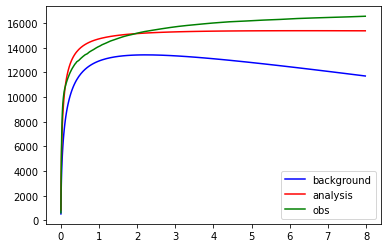

In [44]:
X= (file['X']).values.tolist()[10:]
Y_obs= (file['Y']).values.tolist()[10:]
plt.plot(X,f(x_b),'b',label = 'background')
plt.plot(X,f(x_a),'r',label = 'analysis')
plt.plot(X,np.array(Y_obs)*10,'g',label = 'obs')
plt.legend()

In [45]:
x_a

array([1.20000000e+01, 8.58107358e-01, 5.00000000e+02, 1.02527482e+01,
       7.80856131e+01, 1.50000000e+03])